In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import firedrake
import icepack, icepack.models, icepack.plot

# Ice streams, one more time

In this demo, we'll revisit the ice stream demo but with a different model.
The *hybrid* flow model that we'll use here can resolve both *plug flow* and *shear flow*.
The velocity field is a plug flow if the velocity is roughly constanty with depth, whereas in shear flow the speed at the ice base is much smaller than at the ice surface.
Deep in the interior of an ice sheet, most flow is by vertical shear, whereas the fast ice streams near the margins are roughly in plug flow.
The shallow stream equations, and the `IceStream` class we used to solve them in the third demo, assume plug flow and thus are limited in the regions where they can be applied without substantial error.
The `HybridModel` class we'll use here has no such limitation.

### Geometry and input data

We'll use the same footprint geometry as the ice stream demo, but since we're working with a 3D flow model, we need a 3D mesh to go along with it.
The model we will use is posed entirely in *terrain-following coordinates*, where the $z$-axis is remapped into the interval $[0, 1]$.
This new coordinate is defined as
$$\zeta = \frac{z - b}{h}$$
and the inverse transformation is $z = h\zeta + b$.
In the absence of terminus advance or iceberg calving, the transformation to this coordinate system makes the logical geometry of problem completely steady even though the surface can be rising or falling.

Firedrake includes built-in support generating *extruded meshes* out of a 2D footprint mesh.
Rather than use a large number of vertical layers to achieve high resolution of functions defined on this mesh, we'll use only one layer but high-degree basis functions.

In [2]:
Lx, Ly = 50e3, 12e3
nx, ny = 48, 32
mesh2d = firedrake.RectangleMesh(nx, ny, Lx, Ly)
mesh = firedrake.ExtrudedMesh(mesh2d, layers=1)

To define a function space on an extruded mesh, the only change over 2D function spaces is the addition of the `vfamily` and `vdegree` arguments.
These describe respectively the finite element type and polynomial degree in the vertical direction.
The surface and bed elevation only have to be defined on the footprint mesh, so we'll use vertical basis functions that are constant.

In [3]:
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2, vfamily='DG', vdegree=0)

The function space for the velocities is more interesting.
For starters, we have to explicitly specify the value dimension, since we're workin with a 2D vector field defined on a 3D mesh.
Rather than use the usual continuous or discontinuous Galerkin finite element bases in the vertical, we'll use *Gauss-Legendre* elements.
This finite element uses [Legendre polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials) instead of the Lagrange interpolating polynomials.
The Legendre polynomials are advantageous because they are mutually orthogonal.

In [4]:
V = firedrake.VectorFunctionSpace(mesh, dim=2, family='CG', degree=2, vfamily='GL', vdegree=1)

Creating the input data is mostly the same as before.
The `SpatialCoordinate` function now returns an additional symbol representing the terrain-following coordinate $\zeta$.

In [5]:
from icepack.constants import (ice_density as ρ_I, water_density as ρ_W,
                               gravity as g)

x, y, ζ = firedrake.SpatialCoordinate(mesh)

In [6]:
b_in, b_out = 200, -400
b = firedrake.interpolate(b_in - (b_in - b_out) * x / Lx, Q)

s_in, s_out = 850, 50
s0 = firedrake.interpolate(s_in - (s_in - s_out) * x / Lx, Q)

h0 = firedrake.interpolate(s0 - b, Q)

In [7]:
h_in = s_in - b_in
δs_δx = (s_out - s_in) / Lx
τ_D = -ρ_I * g * h_in * δs_δx

In [8]:
u_in, u_out = 20, 2400
velocity_x = u_in + (u_out - u_in) * (x/Lx)**2
u0 = firedrake.interpolate(firedrake.as_vector((velocity_x, 0)), V)

In [9]:
temp = 255.0
A = firedrake.Constant(icepack.rate_factor(temp))

In [10]:
from icepack.constants import weertman_sliding_law as m
C = (0.95 - 0.40 * firedrake.sin(10*firedrake.pi*x/Lx)) * τ_D / u_in**(1/m)

p_W = ρ_W * g * firedrake.max_value(0, h0 - s0)
p_I = ρ_I * g * h0
ϕ = 1 - p_W / p_I

In [11]:
beta = firedrake.interpolate(C,Q)

In [12]:
print(0.09355600800000001 * (0.95 + -1 * 0.05)*50000/50000.0/2.7144)

0.03101989655172414


The bed friction can be re-parameterized for the hybrid model in the same way as for the ice stream model.

In [13]:
import icepack.models.hybrid
def friction(u, h, s, C):
    p_W = ρ_W * g * firedrake.max_value(0, h - s)
    p_I = ρ_I * g * h
    ϕ = 1 - p_W / p_I
    return icepack.models.hybrid.bed_friction(u, C * ϕ)

In [16]:
model = icepack.models.HybridModel(friction=friction)
solver = icepack.solvers.FlowSolver(model)
opts = {'dirichlet_ids': [1], 'side_wall_ids': [3, 4], 'tol': 1e-6}
u0 = solver.diagnostic_solve(u0=u0, h=h0, s=s0, A=A, C=C, **opts)

TypeError: Input fields must be Constant or Function!

The `tricontourf` function in icepack will detect whether you're trying to plot a 2D or a 3D field.
Plotting 3D fields is expensive, so as a default, this function will depth-average the input field and make a contour plot of the resulting 2D field.

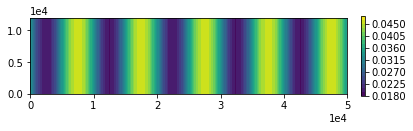

In [60]:
fig, axes = icepack.plot.subplots()
contours = icepack.plot.tricontourf(beta, 25, axes=axes)
fig.colorbar(contours, ax=axes, fraction=0.012, pad=0.04)
plt.show(fig)

### Modeling

The code to run the hybrid model is identical to that of the ice stream demo.

In [61]:
num_years = 250
timesteps_per_year = 2

δt = 1.0/timesteps_per_year
num_timesteps = num_years * timesteps_per_year

a = 1.7 - 2.7 * x / Lx
h = h0.copy(deepcopy=True)
u = u0.copy(deepcopy=True)

for k in range(num_timesteps + 1):
    h = model.prognostic_solve(δt, h0=h, a=a, u=u, h_inflow=h0)
    s = model.compute_surface(h=h, b=b)
    u = model.diagnostic_solve(u0=u, h=h, s=s, A=A, C=C, **opts)
    print('.' if k * δt % 10 == 0 else '', end='')

..........................

As a sanity check, we can plot the thickness, velocity, and mass balance.
These give very similar results in the eyeball norm to our previous demo assuming only plug flow.

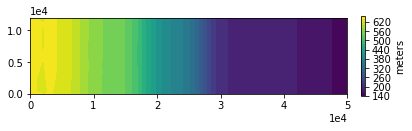

In [62]:
fig, axes = icepack.plot.subplots()
contours =  icepack.plot.tricontourf(h, 25, axes=axes)
fig.colorbar(contours, label='meters', fraction=0.012, pad=0.04)
plt.show(fig)

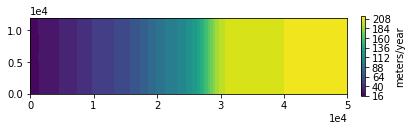

In [63]:
fig, axes = icepack.plot.subplots()
contours = icepack.plot.tricontourf(u, 25, axes=axes)
fig.colorbar(contours, label='meters/year', fraction=0.012, pad=0.04)
plt.show(fig)

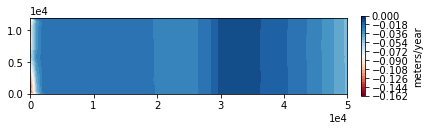

In [64]:
def div_2(v):
    return v[0].dx(0) + v[1].dx(1)

f = firedrake.project(a - div_2(h * u), Q)
fig, axes = icepack.plot.subplots()
contours = icepack.plot.tricontourf(f, 25, cmap='RdBu', axes=axes)
fig.colorbar(contours, label='meters/year', fraction=0.012, pad=0.04)
plt.show(fig)

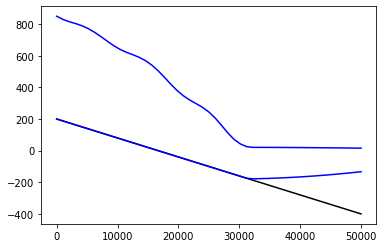

In [65]:
import numpy as np
xs = np.array([(Lx * k / nx, 0, .5) for k in range(nx + 1)])
ss = np.array(s.at(xs, tolerance=1e-10))
hs = np.array(h.at(xs, tolerance=1e-10))
bs = np.array(b.at(xs, tolerance=1e-10))

fig, axes = plt.subplots()
axes.plot(xs[:, 0], bs, color='black')
axes.plot(xs[:, 0], ss - hs, color='blue')
axes.plot(xs[:, 0], ss, color='blue')
plt.show(fig)

In [66]:
import icepack.models.layers
slps=icepack.models.layers.slopes()
slopes=firedrake.interpolate(firedrake.as_vector((0.0,0.0)),V)
w=icepack.models.layers.orthogonal_velocity(u,h)

In [67]:
slopes=slps.solve(u=u,h=h)

In [68]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

nz=10

xz = np.array([(Lx * k / nx, 0, i)  for k in range(nx + 1) for i in np.arange(0,1.0,1.0/nz)])
slopes= np.array(slopes.at(xz, tolerance=1e-10))
uz = np.array(u.at(xz, tolerance=1e-10))
wz = np.array(w.at(xz, tolerance=1e-10))
slopes=np.reshape(np.degrees(slopes),(49,10,2));
wz=np.reshape(wz,(49,10));
uz=np.reshape(uz,(49,10,2));
xz=np.reshape(xz,(49,10,3));
hz=np.reshape(np.repeat(hs,10),(49,10));
hz=np.multiply(xz[:,:,2],hz,);



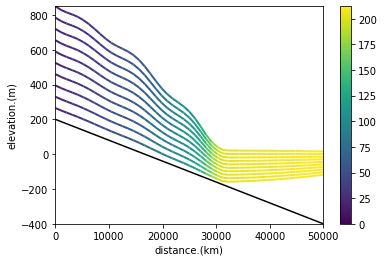

In [69]:
fig, axs = plt.subplots()
for i in range(0,10):
    points = np.array([np.squeeze(xz[:,i,0]),np.squeeze(ss-hz[:,i])]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(uz.min(), uz.max())
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.squeeze(uz[:,i,0]))
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
axs.set_xlim(xz.min(), xz.max())
axs.set_ylim(bs.min(), ss.max())
axs.plot(xs[:, 0], bs, color='black')
fig.colorbar(line, ax=axs)    
axs.set_ylabel('elevation.(m)')
axs.set_xlabel('distance.(km)')
plt.show()

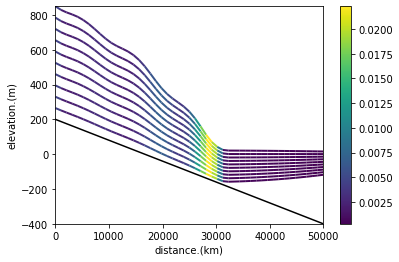

In [70]:
fig, axs = plt.subplots()
for i in range(0,10):
    points = np.array([np.squeeze(xz[:,i,0]),np.squeeze(ss-hz[:,i])]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(wz.min(), wz.max())
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.squeeze(wz[:,i]))
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
axs.set_xlim(xz.min(), xz.max())
axs.set_ylim(bs.min(), ss.max())
axs.plot(xs[:, 0], bs, color='black')
fig.colorbar(line, ax=axs)    
axs.set_ylabel('elevation.(m)')
axs.set_xlabel('distance.(km)')
plt.show()

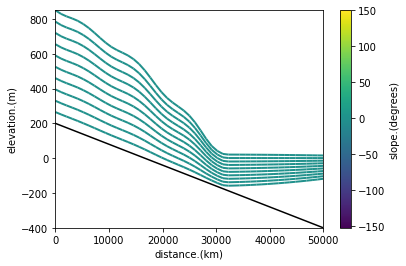

In [71]:
fig, axs = plt.subplots()
for i in range(0,10):
    points = np.array([np.squeeze(xz[:,i,0]),np.squeeze(ss-hz[:,i])]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(slopes[1:-1].min(), slopes.max())
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.squeeze(slopes[:,i,0]))
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
axs.set_xlim(xz.min(), xz.max())
axs.set_ylim(bs.min(), ss.max())
axs.plot(xs[:, 0], bs, color='black')
fig.colorbar(line, ax=axs,label='slope.(degrees)')    
axs.set_ylabel('elevation.(m)')
axs.set_xlabel('distance.(km)')
plt.show()

Text(0.5, 0, 'distance.(km)')

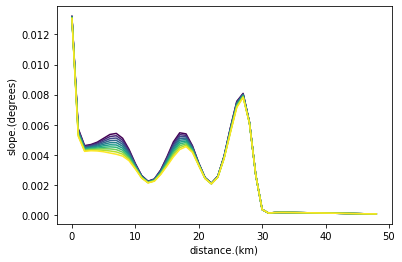

In [72]:
import matplotlib
fig, axs = plt.subplots()
colormap = plt.get_cmap('hsv')

colors = plt.cm.viridis(np.linspace(0,1,10))
for i in range(0,10):
    axs.plot(slopes[:,i,0],color=colors[i])
axs.set_ylabel('slope.(degrees)')
axs.set_xlabel('distance.(km)')

### Resolving shear flow

Unlike the ice stream model, however, the hybrid model can resolve vertical shear flow.
To quantity the degree to which the glacier is in plug flow vs shear flow, we can calculate a weighted depth average of the velocity.
In this case, we'll use the function
$$q(\zeta) = \sqrt 3 \cdot (2\zeta - 1)$$
as our weight function.
This weight is odd when reflected over the axis $\zeta = 1/2$, so it's orthogonal to all plug flow fields.
The extra factor of $\sqrt 3$ is there to normalize the weight function so that
$$\int_0^1q(\zeta)^2d\zeta = 1.$$
This weight is actually just the degree-1 Legendre polynomial, normalized and shifted over to the interval $[0, 1]$.

The function `depth_average` will evaluate a weighted depth average of a 3D field defined on an extruded mesh.
The weight can be any expression; in our case we're using a polynomial in the symbol $\zeta$, but we could also have used another finite element function.

In [73]:
u_shear = icepack.depth_average(u, weight=np.sqrt(3) * (2 * ζ - 1))

The resulting field is defined on the 2D footprint mesh as opposed to the 3D extruded mesh.

In [74]:
u_shear.ufl_domain() is mesh2d

True

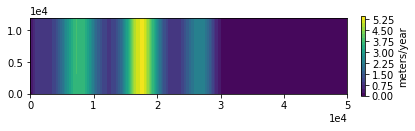

In [75]:
fig, axes = icepack.plot.subplots()
contours = icepack.plot.tricontourf(u_shear, 25, axes=axes)
fig.colorbar(contours, label='meters/year', fraction=0.012, pad=0.04)
plt.show(fig)

The region where the velocity has a significant shear flow component is confined to the left half of the domain, where the ice is grounded.
There is virtually no shear flow at all in the right half of the domain where the ice is floating, just as we expect.
To be more exact, we can also calculate the unweighted depth average of the velocity and take the ratio of the two components.

In [ ]:
from firedrake import inner, sqrt
u_avg = icepack.depth_average(u)

Q2D = firedrake.FunctionSpace(mesh2d, family='CG', degree=2)
U_shear = sqrt(inner(u_shear, u_shear))
U_avg = sqrt(inner(u_avg, u_avg))
ratio = firedrake.interpolate(U_shear / U_avg, Q2D)

In [ ]:
fig, axes = icepack.plot.subplots()
contours = icepack.plot.tricontourf(ratio, 25, axes=axes)
fig.colorbar(contours, fraction=0.012, pad=0.04)
plt.show(fig)

The shear/plug ratio tops out at around 6\%.
For comparison, when the vertical velocity profile follows the shallow ice approximation, the horizontal velocity is a quartic polynomial in the vertical:
$$u \propto 1 - (1 - \zeta)^4.$$
In this case, the shear/plug ratio can be calculated by hand to be $\frac{1}{2\sqrt3} \approx 29\%$.
We could arrive at a different shear ratio in steady state by using a larger value for the basal friction coefficient.

### Conclusion

In this demo, we showed how to use a hybrid model that can capture both plug and shear flow.
The biggest differences between this model and the ice stream model we showed earlier are that you need to create an extruded mesh and that you need to specify the element family and degree in the vertical dimension.
Using spectral methods in the vertical dimension makes it possible to capture much of the variation along this axis without resorting to a large number of layers, as might be necessary if we were using a more "traditional" discretization.
There are also a few extra steps when you want to analyze or plot 3D fields; depth averaging with a good choice of vertical weight function can get you pretty far.
In principle, this hybrid model will work well on much larger spatial scales such as an entire glacier drainage basin or even a whole ice sheet.

### Epilogue: bootstrapping

When we chose a function space to represent the velocity field, we used a vertical degree of 1, which can resolve linear vertical variations.
Under the shallow ice approximation, the ice velocity is a quartic polynomial in $\zeta$, so using a degree of at least 4 might have been a more sensible choice.

The degree-1 solution can still be useful as a cheaper initial guess for the degree-4 solution.
We rarely have a good initial guess for what the steady-state velocity will be, and computing it from a cold start as we did for the degree-1 solution can be more expensive the more vertical modes we use.
Instead, we can run the degree-1 velocity and thickness to steady state and use this to initialize a (hopefully cheaper) degree-4 solution.

In [ ]:
V_1 = firedrake.VectorFunctionSpace(mesh, dim=2, family='CG', degree=2, vfamily='GL', vdegree=1)
u_1 = firedrake.interpolate(u, V_1)

V_4 = firedrake.VectorFunctionSpace(mesh, dim=2, family='CG', degree=2, vfamily='GL', vdegree=4)
u_4 = firedrake.interpolate(u, V_4)

u_4 = model.diagnostic_solve(u0=u_4, h=h, s=s, A=A, C=C, **opts)

To see how much of a change we get with the extra vertical modes, we'll calculate the relative error in the 2-norm.

In [ ]:
δu = firedrake.interpolate(u_4 - u_1, V_4)
print(firedrake.norm(δu) / firedrake.norm(u_4))

A mismatch of only 3\% is not bad at all!
However, if we used a synthetic glacier that were closer to the idealized shallow ice approximation then the error would be larger.
The accuracy of the degree-1 solution in this particular case should not be extrapolated to all scenarios.

When we initialize the glacier from a rough initial guess as we did for the degree-1, we have to expect that it will take the entire residence time for any initial transients to propagate out, which in our case is in excess of 100 years.
If we initialize a degree-4 solution from the steady state degree-1 solution we may be able to get away with a much shorter spin-up period.